In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_steps = pd.DataFrame()
for file in glob.glob("./ChrisMartin/user-site-export/steps-*.json"):
    print(file)
    df_file = pd.read_json(file,orient='records')
    df_steps = df_steps.append(df_file)

./ChrisMartin/user-site-export/steps-2016-09-16.json
./ChrisMartin/user-site-export/steps-2018-02-08.json
./ChrisMartin/user-site-export/steps-2017-08-12.json
./ChrisMartin/user-site-export/steps-2016-05-19.json
./ChrisMartin/user-site-export/steps-2016-08-17.json
./ChrisMartin/user-site-export/steps-2016-10-16.json
./ChrisMartin/user-site-export/steps-2017-03-15.json
./ChrisMartin/user-site-export/steps-2015-02-24.json
./ChrisMartin/user-site-export/steps-2014-11-26.json
./ChrisMartin/user-site-export/steps-2014-10-27.json
./ChrisMartin/user-site-export/steps-2015-10-22.json
./ChrisMartin/user-site-export/steps-2018-12-05.json
./ChrisMartin/user-site-export/steps-2015-08-23.json
./ChrisMartin/user-site-export/steps-2015-09-22.json
./ChrisMartin/user-site-export/steps-2014-09-27.json
./ChrisMartin/user-site-export/steps-2016-01-20.json
./ChrisMartin/user-site-export/steps-2016-04-19.json
./ChrisMartin/user-site-export/steps-2017-01-14.json
./ChrisMartin/user-site-export/steps-2016-07-1

In [3]:
df_steps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1894273 entries, 0 to 41983
Data columns (total 2 columns):
dateTime    datetime64[ns]
value       int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 43.4 MB


In [4]:
df_steps.head()

,dateTime,value
0,2016-09-15 22:00:00,0
1,2016-09-15 22:01:00,0
2,2016-09-15 22:02:00,0
3,2016-09-15 22:03:00,0
4,2016-09-15 22:04:00,0


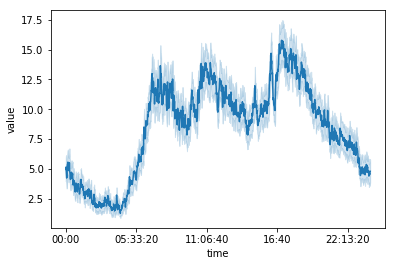

In [6]:
df_steps = df_steps.set_index('dateTime')
first_day = (df_steps.index.min()).date()
last_day = (df_steps.index.max()).date()
sns.lineplot(x=df_steps.index.time,y='value',data=df_steps)

In [7]:
df_day_sum = df_steps.groupby(df_steps.index.to_period('d')).cumsum()

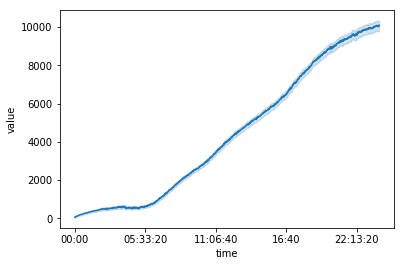

In [9]:
sns.lineplot(x=df_day_sum.index.time,y='value',data=df_day_sum)

In [10]:
sum_steps_easy = pd.DataFrame(df_steps.groupby(df_steps.index.date).sum())
sum_steps_easy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1620 entries, 2014-08-29 to 2019-03-26
Data columns (total 1 columns):
value    1620 non-null int64
dtypes: int64(1)
memory usage: 25.3+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a29b16dd8>]],
      dtype=object)

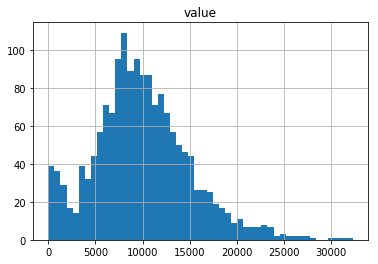

In [11]:
sum_steps_easy.hist(bins=50)

In [12]:
sum_steps_easy_v2 = sum_steps_easy[sum_steps_easy['value'] > 1500]

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1de25b00>]],
      dtype=object)

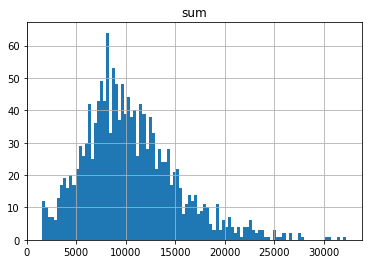

In [13]:
sum_steps_easy_v2['sum'] = sum_steps_easy_v2['value']
sum_steps_easy_v2 = sum_steps_easy_v2.drop('value',axis=1)
sum_steps_easy_v2.hist(bins=100)

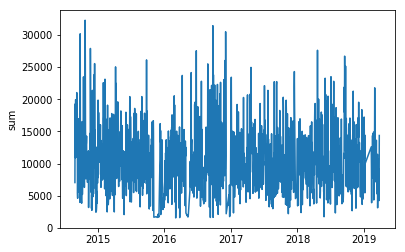

In [14]:
sns.lineplot(x=sum_steps_easy_v2.index,y='sum',data=sum_steps_easy_v2)

In [15]:
missing_dates = pd.date_range(start = '2014-08-29', end = '2019-03-26' ).difference(sum_steps_easy_v2.index)

In [16]:
print(missing_dates)

DatetimeIndex(['2014-10-19', '2015-03-30', '2015-08-06', '2015-08-07',
               '2015-08-08', '2015-08-09', '2015-11-06', '2015-11-07',
               '2015-11-08', '2015-11-09',
               ...
               '2019-01-31', '2019-02-01', '2019-02-02', '2019-02-03',
               '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07',
               '2019-02-08', '2019-02-09'],
              dtype='datetime64[ns]', length=140, freq=None)


In [17]:
sum_steps_easy_v2['date_np'] = sum_steps_easy_v2.index.to_series().apply(lambda x: np.datetime64(str(x)))

In [18]:
sum_steps_easy_v2.head()


,sum,date_np
2014-08-29,7056,2014-08-29
2014-08-30,19267,2014-08-30
2014-08-31,12454,2014-08-31
2014-09-01,10891,2014-09-01
2014-09-02,19943,2014-09-02


In [19]:
sum_steps_easy_v2 = sum_steps_easy_v2.reset_index()

In [20]:
sum_steps_easy_v2 = sum_steps_easy_v2.drop('index',axis=1)

In [21]:
sum_steps_easy_v2.head()

,sum,date_np
0,7056,2014-08-29
1,19267,2014-08-30
2,12454,2014-08-31
3,10891,2014-09-01
4,19943,2014-09-02


In [23]:
sum_steps_easy_v2['day_of_week'] = sum_steps_easy_v2['date_np'].dt.dayofweek

In [52]:
sum_steps_easy_v2['weekend'] = sum_steps_easy_v2['day_of_week'].apply(lambda x: x > 4)
sum_steps_easy_v2 = sum_steps_easy_v2.drop('day_of_week',axis=1)

In [53]:
sum_steps_easy_v2.head()

,sum,date_np,weekend
0,7056,2014-08-29,False
1,19267,2014-08-30,True
2,12454,2014-08-31,True
3,10891,2014-09-01,False
4,19943,2014-09-02,False


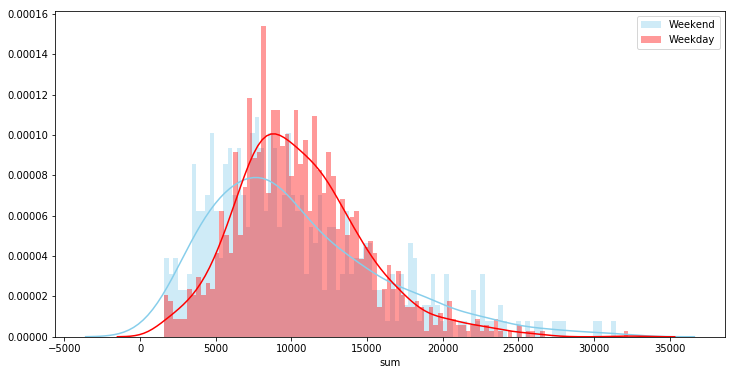

In [54]:
axis = plt.figure(figsize=(12,6))
sns.distplot( sum_steps_easy_v2.loc[sum_steps_easy_v2['weekend'] == True,'sum'] , color="skyblue", label="Weekend",bins=100)
sns.distplot( sum_steps_easy_v2.loc[sum_steps_easy_v2['weekend'] == False,'sum'] , color="red", label="Weekday",bins=100)
plt.legend()
plt.show()

In [55]:
df_sleep = pd.DataFrame()
for file in glob.glob("./ChrisMartin/user-site-export/sleep-*.json"):
    print(file)
    df_file = pd.read_json(file,orient='records')
    df_sleep = df_sleep.append(df_file)

./ChrisMartin/user-site-export/sleep-2014-09-27.json
./ChrisMartin/user-site-export/sleep-2016-01-20.json
./ChrisMartin/user-site-export/sleep-2016-04-19.json
./ChrisMartin/user-site-export/sleep-2014-11-26.json
./ChrisMartin/user-site-export/sleep-2014-10-27.json
./ChrisMartin/user-site-export/sleep-2018-12-05.json
./ChrisMartin/user-site-export/sleep-2016-10-16.json
./ChrisMartin/user-site-export/sleep-2017-03-15.json
./ChrisMartin/user-site-export/sleep-2015-02-24.json
./ChrisMartin/user-site-export/sleep-2016-09-16.json
./ChrisMartin/user-site-export/sleep-2018-02-08.json
./ChrisMartin/user-site-export/sleep-2017-08-12.json
./ChrisMartin/user-site-export/sleep-2016-05-19.json
./ChrisMartin/user-site-export/sleep-2016-08-17.json
./ChrisMartin/user-site-export/sleep-2015-01-25.json
./ChrisMartin/user-site-export/sleep-2014-12-26.json
./ChrisMartin/user-site-export/sleep-2017-02-13.json
./ChrisMartin/user-site-export/sleep-2018-11-05.json
./ChrisMartin/user-site-export/sleep-2016-06-1

In [56]:
df_sleep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1583 entries, 0 to 34
Data columns (total 14 columns):
dateOfSleep            1583 non-null object
duration               1583 non-null int64
efficiency             1583 non-null int64
endTime                1583 non-null object
infoCode               1583 non-null int64
levels                 1583 non-null object
logId                  1583 non-null int64
minutesAfterWakeup     1583 non-null int64
minutesAsleep          1583 non-null int64
minutesAwake           1583 non-null int64
minutesToFallAsleep    1583 non-null int64
startTime              1583 non-null object
timeInBed              1583 non-null int64
type                   1583 non-null object
dtypes: int64(9), object(5)
memory usage: 185.5+ KB


In [57]:
df_sleep['date_np'] = df_sleep['dateOfSleep'].apply(lambda x: np.datetime64(str(x)))

In [58]:
sum_sleep = df_sleep.groupby(df_sleep['date_np']).sum()

In [59]:
sum_sleep.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1355 entries, 2014-08-30 to 2019-03-26
Data columns (total 9 columns):
duration               1355 non-null int64
efficiency             1355 non-null int64
infoCode               1355 non-null int64
logId                  1355 non-null int64
minutesAfterWakeup     1355 non-null int64
minutesAsleep          1355 non-null int64
minutesAwake           1355 non-null int64
minutesToFallAsleep    1355 non-null int64
timeInBed              1355 non-null int64
dtypes: int64(9)
memory usage: 105.9 KB


In [60]:
sum_sleep = sum_sleep.reset_index()
sum_sleep['day_of_week'] = sum_sleep['date_np'].dt.dayofweek
sum_sleep['weekend'] = sum_sleep['day_of_week'].apply(lambda x: x > 4)

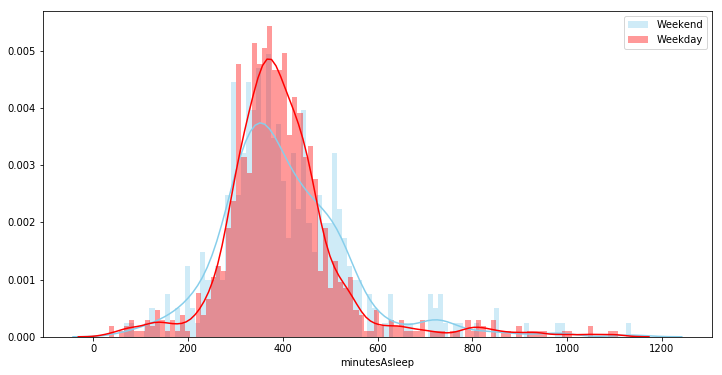

In [61]:
axis = plt.figure(figsize=(12,6))
sns.distplot( sum_sleep.loc[sum_sleep['weekend'] == True,'minutesAsleep'] , color="skyblue", label="Weekend",bins=100)
sns.distplot( sum_sleep.loc[sum_sleep['weekend'] == False,'minutesAsleep'] , color="red", label="Weekday",bins=100)
plt.legend()
plt.show()

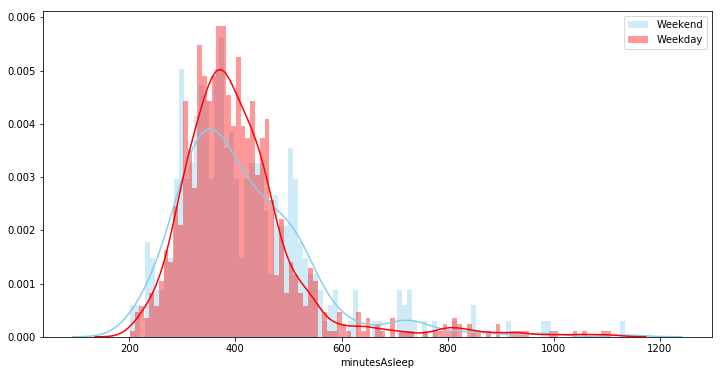

In [62]:
sum_sleep = sum_sleep[sum_sleep['minutesAsleep'] > 200]
axis = plt.figure(figsize=(12,6))
sns.distplot( sum_sleep.loc[sum_sleep['weekend'] == True,'minutesAsleep'] , color="skyblue", label="Weekend",bins=100)
sns.distplot( sum_sleep.loc[sum_sleep['weekend'] == False,'minutesAsleep'] , color="red", label="Weekday",bins=100)
plt.legend()
plt.show()

In [63]:
sum_sleep = sum_sleep.drop(['infoCode','logId','day_of_week'],axis=1)

/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


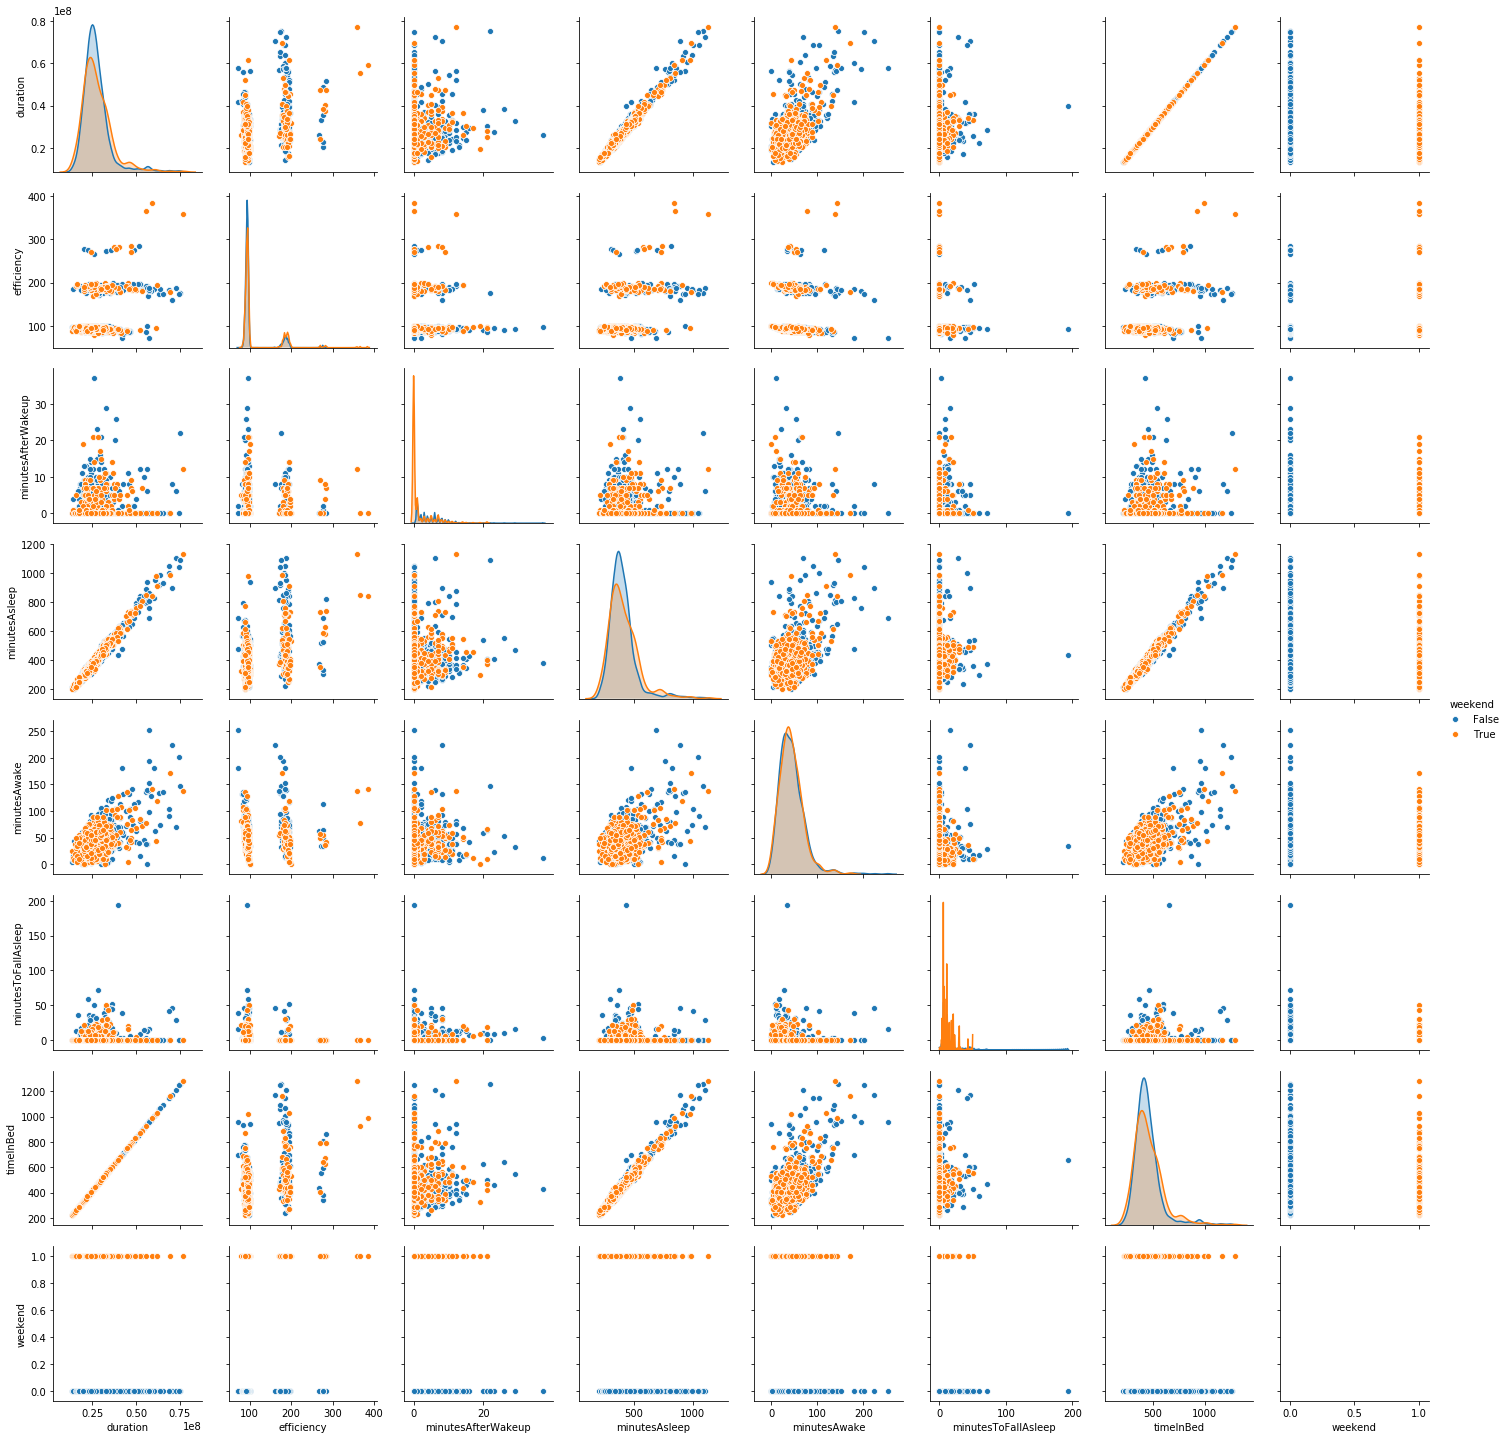

In [64]:
sns.pairplot(sum_sleep,hue='weekend')

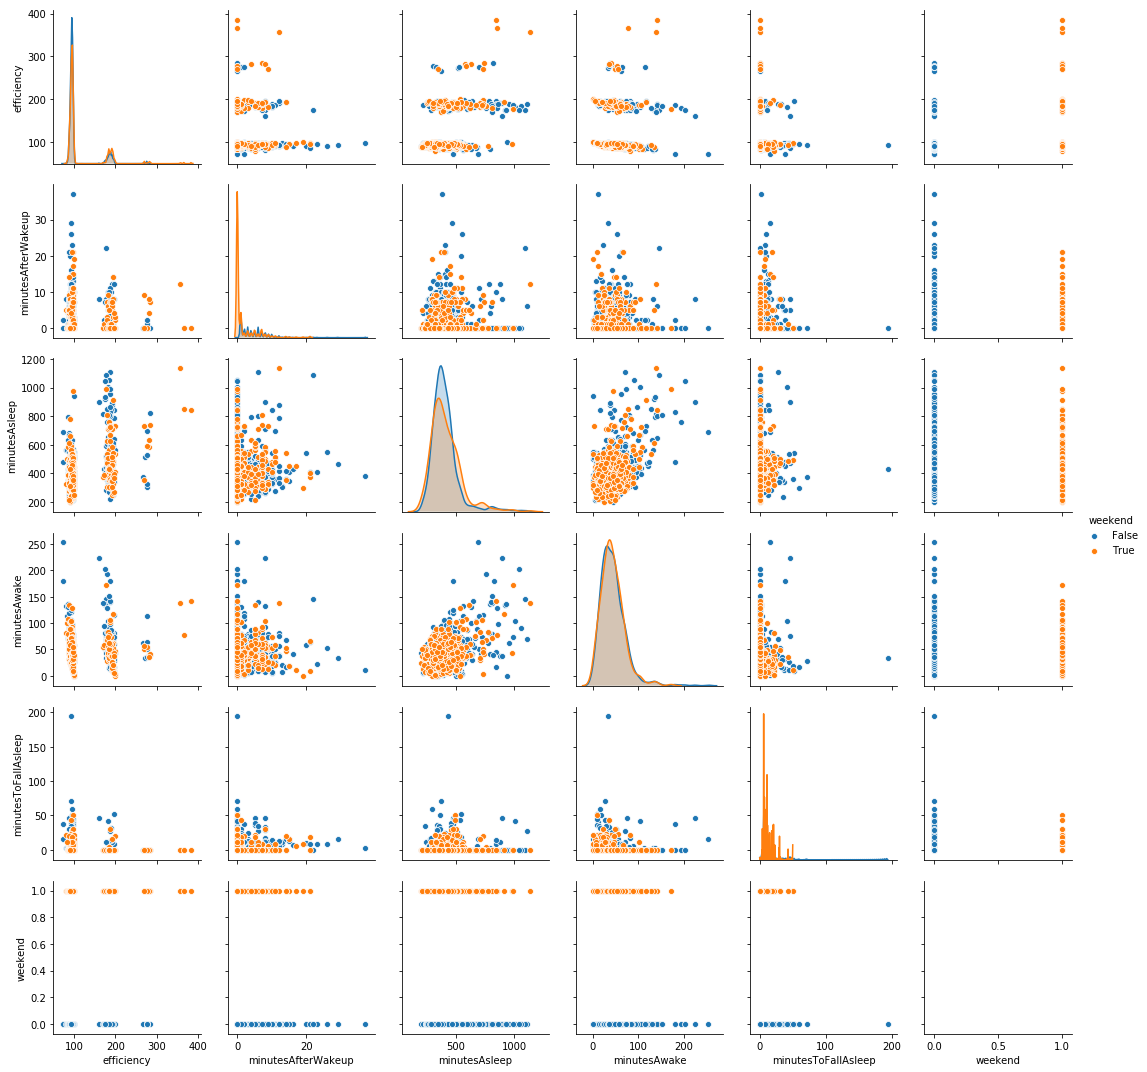

In [65]:
sum_sleep = sum_sleep.drop(['timeInBed','duration'],axis=1)
sns.pairplot(sum_sleep,hue='weekend')

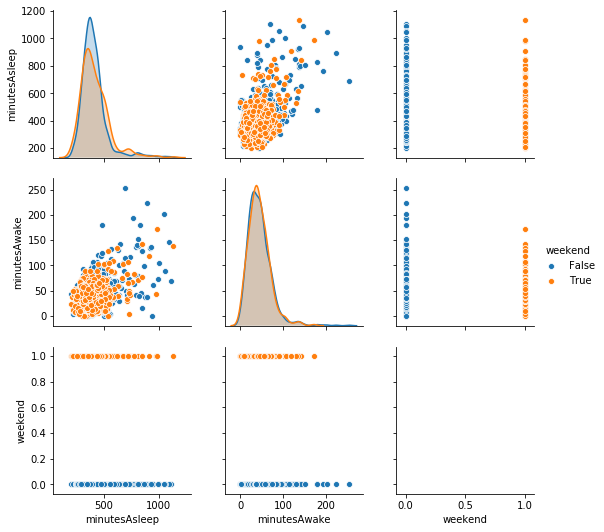

In [66]:
sum_sleep = sum_sleep.drop(['efficiency','minutesToFallAsleep','minutesAfterWakeup'],axis=1)
sns.pairplot(sum_sleep,hue='weekend')

In [67]:
Merged = sum_steps_easy_v2.merge(sum_sleep,on=['weekend','date_np'],how='inner')

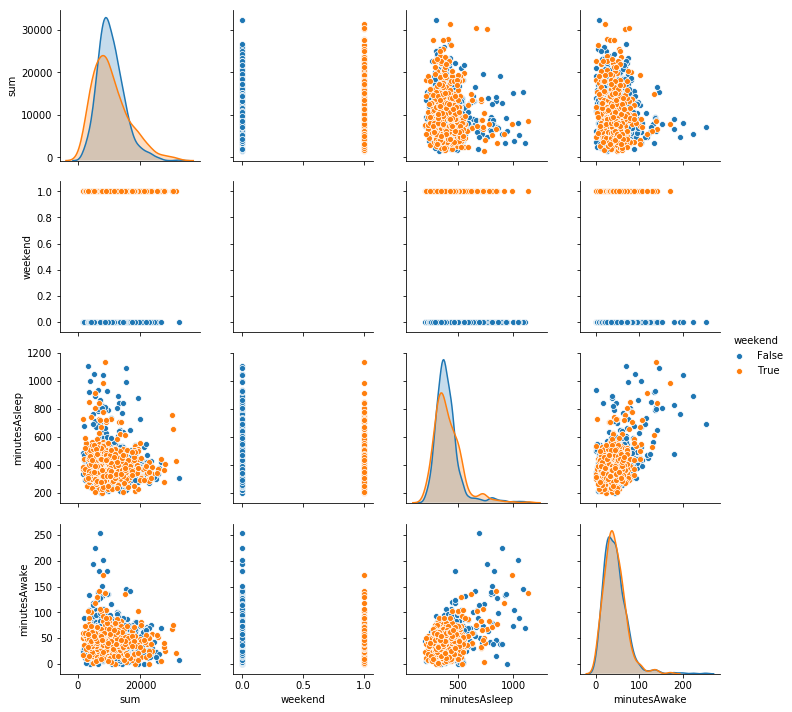

In [68]:
sns.pairplot(Merged,hue='weekend')

In [69]:
Merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1275 entries, 0 to 1274
Data columns (total 5 columns):
sum              1275 non-null int64
date_np          1275 non-null datetime64[ns]
weekend          1275 non-null bool
minutesAsleep    1275 non-null int64
minutesAwake     1275 non-null int64
dtypes: bool(1), datetime64[ns](1), int64(3)
memory usage: 91.0 KB


In [70]:
Merged[Merged.weekend].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 1272
Data columns (total 5 columns):
sum              351 non-null int64
date_np          351 non-null datetime64[ns]
weekend          351 non-null bool
minutesAsleep    351 non-null int64
minutesAwake     351 non-null int64
dtypes: bool(1), datetime64[ns](1), int64(3)
memory usage: 14.1 KB


./ChrisMartin/user-site-export/sedentary_minutes-2018-08-07.json
./ChrisMartin/user-site-export/sedentary_minutes-2018-05-09.json
./ChrisMartin/user-site-export/sedentary_minutes-2018-09-06.json
./ChrisMartin/user-site-export/sedentary_minutes-2017-04-14.json
./ChrisMartin/user-site-export/sedentary_minutes-2019-03-05.json
./ChrisMartin/user-site-export/sedentary_minutes-2015-05-25.json
./ChrisMartin/user-site-export/sedentary_minutes-2015-12-21.json
./ChrisMartin/user-site-export/sedentary_minutes-2018-10-06.json
./ChrisMartin/user-site-export/sedentary_minutes-2017-06-13.json
./ChrisMartin/user-site-export/sedentary_minutes-2016-12-15.json
./ChrisMartin/user-site-export/sedentary_minutes-2017-05-14.json
./ChrisMartin/user-site-export/sedentary_minutes-2017-12-10.json
./ChrisMartin/user-site-export/sedentary_minutes-2015-04-25.json
./ChrisMartin/user-site-export/sedentary_minutes-2017-07-13.json
./ChrisMartin/user-site-export/sedentary_minutes-2018-04-09.json
./ChrisMartin/user-site-e

/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


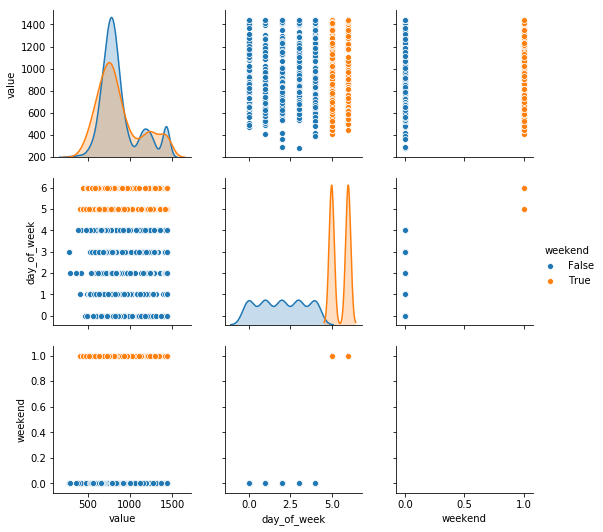

In [72]:
df_sed = pd.DataFrame()
for file in glob.glob("./ChrisMartin/user-site-export/sedentary_minutes-*.json"):
    print(file)
    df_file = pd.read_json(file,orient='records')
    df_sed = df_sed.append(df_file)
df_sed.info()
print("Unique dates: ",df_sed['dateTime'].nunique())
df_sed['day_of_week'] = df_sed['dateTime'].dt.dayofweek
df_sed['weekend'] = df_sed['day_of_week'].apply(lambda x: x > 4)
sns.pairplot(df_sed,hue='weekend')

./ChrisMartin/user-site-export/very_active_minutes-2017-07-13.json
./ChrisMartin/user-site-export/very_active_minutes-2015-04-25.json
./ChrisMartin/user-site-export/very_active_minutes-2017-05-14.json
./ChrisMartin/user-site-export/very_active_minutes-2017-12-10.json
./ChrisMartin/user-site-export/very_active_minutes-2016-12-15.json
./ChrisMartin/user-site-export/very_active_minutes-2018-04-09.json
./ChrisMartin/user-site-export/very_active_minutes-2016-02-19.json
./ChrisMartin/user-site-export/very_active_minutes-2018-09-06.json
./ChrisMartin/user-site-export/very_active_minutes-2018-05-09.json
./ChrisMartin/user-site-export/very_active_minutes-2018-08-07.json
./ChrisMartin/user-site-export/very_active_minutes-2017-06-13.json
./ChrisMartin/user-site-export/very_active_minutes-2015-05-25.json
./ChrisMartin/user-site-export/very_active_minutes-2019-03-05.json
./ChrisMartin/user-site-export/very_active_minutes-2018-10-06.json
./ChrisMartin/user-site-export/very_active_minutes-2015-12-21.

/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


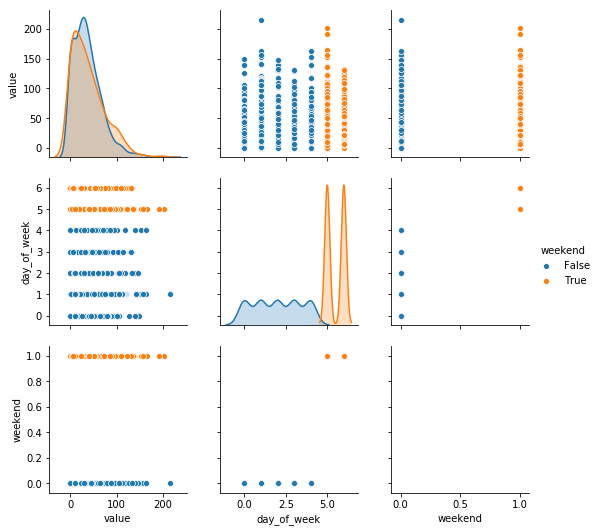

In [74]:
df_va = pd.DataFrame()
for file in glob.glob("./ChrisMartin/user-site-export/very_active_minutes-*.json"):
    print(file)
    df_file = pd.read_json(file,orient='records')
    df_va = df_va.append(df_file)
df_va.info()
print("Unique dates: ",df_va['dateTime'].nunique())
df_va['day_of_week'] = df_va['dateTime'].dt.dayofweek
df_va['weekend'] = df_va['day_of_week'].apply(lambda x: x > 4)
sns.pairplot(df_va,hue='weekend')

./ChrisMartin/user-site-export/lightly_active_minutes-2016-02-19.json
./ChrisMartin/user-site-export/lightly_active_minutes-2018-04-09.json
./ChrisMartin/user-site-export/lightly_active_minutes-2017-12-10.json
./ChrisMartin/user-site-export/lightly_active_minutes-2017-05-14.json
./ChrisMartin/user-site-export/lightly_active_minutes-2016-12-15.json
./ChrisMartin/user-site-export/lightly_active_minutes-2017-07-13.json
./ChrisMartin/user-site-export/lightly_active_minutes-2015-04-25.json
./ChrisMartin/user-site-export/lightly_active_minutes-2017-04-14.json
./ChrisMartin/user-site-export/lightly_active_minutes-2017-06-13.json
./ChrisMartin/user-site-export/lightly_active_minutes-2015-12-21.json
./ChrisMartin/user-site-export/lightly_active_minutes-2018-10-06.json
./ChrisMartin/user-site-export/lightly_active_minutes-2019-03-05.json
./ChrisMartin/user-site-export/lightly_active_minutes-2015-05-25.json
./ChrisMartin/user-site-export/lightly_active_minutes-2018-08-07.json
./ChrisMartin/user-s

/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


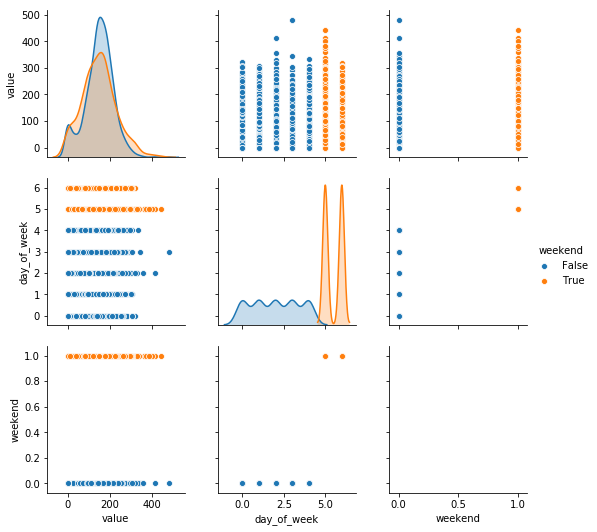

In [75]:
df_la = pd.DataFrame()
for file in glob.glob("./ChrisMartin/user-site-export/lightly_active_minutes-*.json"):
    print(file)
    df_file = pd.read_json(file,orient='records')
    df_la = df_la.append(df_file)
df_la.info()
print("Unique dates: ",df_la['dateTime'].nunique())
df_la['day_of_week'] = df_la['dateTime'].dt.dayofweek
df_la['weekend'] = df_la['day_of_week'].apply(lambda x: x > 4)
sns.pairplot(df_la,hue='weekend')

./ChrisMartin/user-site-export/moderately_active_minutes-2018-07-08.json
./ChrisMartin/user-site-export/moderately_active_minutes-2015-07-24.json
./ChrisMartin/user-site-export/moderately_active_minutes-2019-01-04.json
./ChrisMartin/user-site-export/moderately_active_minutes-2015-03-26.json
./ChrisMartin/user-site-export/moderately_active_minutes-2018-03-10.json
./ChrisMartin/user-site-export/moderately_active_minutes-2015-11-21.json
./ChrisMartin/user-site-export/moderately_active_minutes-2014-08-28.json
./ChrisMartin/user-site-export/moderately_active_minutes-2015-06-24.json
./ChrisMartin/user-site-export/moderately_active_minutes-2017-11-10.json
./ChrisMartin/user-site-export/moderately_active_minutes-2016-11-15.json
./ChrisMartin/user-site-export/moderately_active_minutes-2019-02-03.json
./ChrisMartin/user-site-export/moderately_active_minutes-2017-10-11.json
./ChrisMartin/user-site-export/moderately_active_minutes-2017-09-11.json
./ChrisMartin/user-site-export/moderately_active_mi

/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


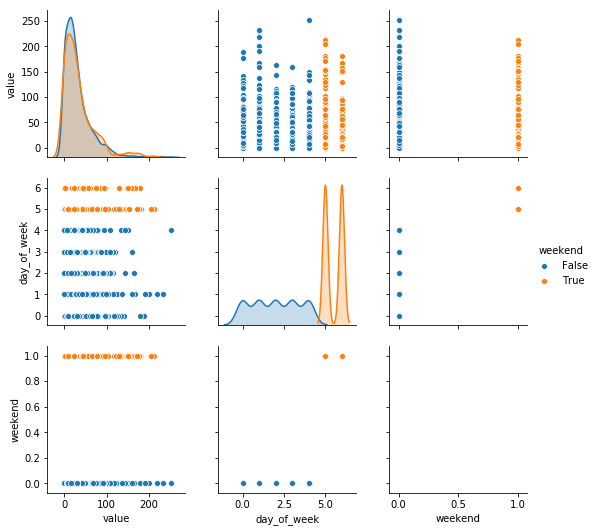

In [76]:
df_ma = pd.DataFrame()
for file in glob.glob("./ChrisMartin/user-site-export/moderately_active_minutes-*.json"):
    print(file)
    df_file = pd.read_json(file,orient='records')
    df_ma = df_ma.append(df_file)
df_ma.info()
print("Unique dates: ",df_ma['dateTime'].nunique())
df_ma['day_of_week'] = df_ma['dateTime'].dt.dayofweek
df_ma['weekend'] = df_ma['day_of_week'].apply(lambda x: x > 4)
sns.pairplot(df_ma,hue='weekend')

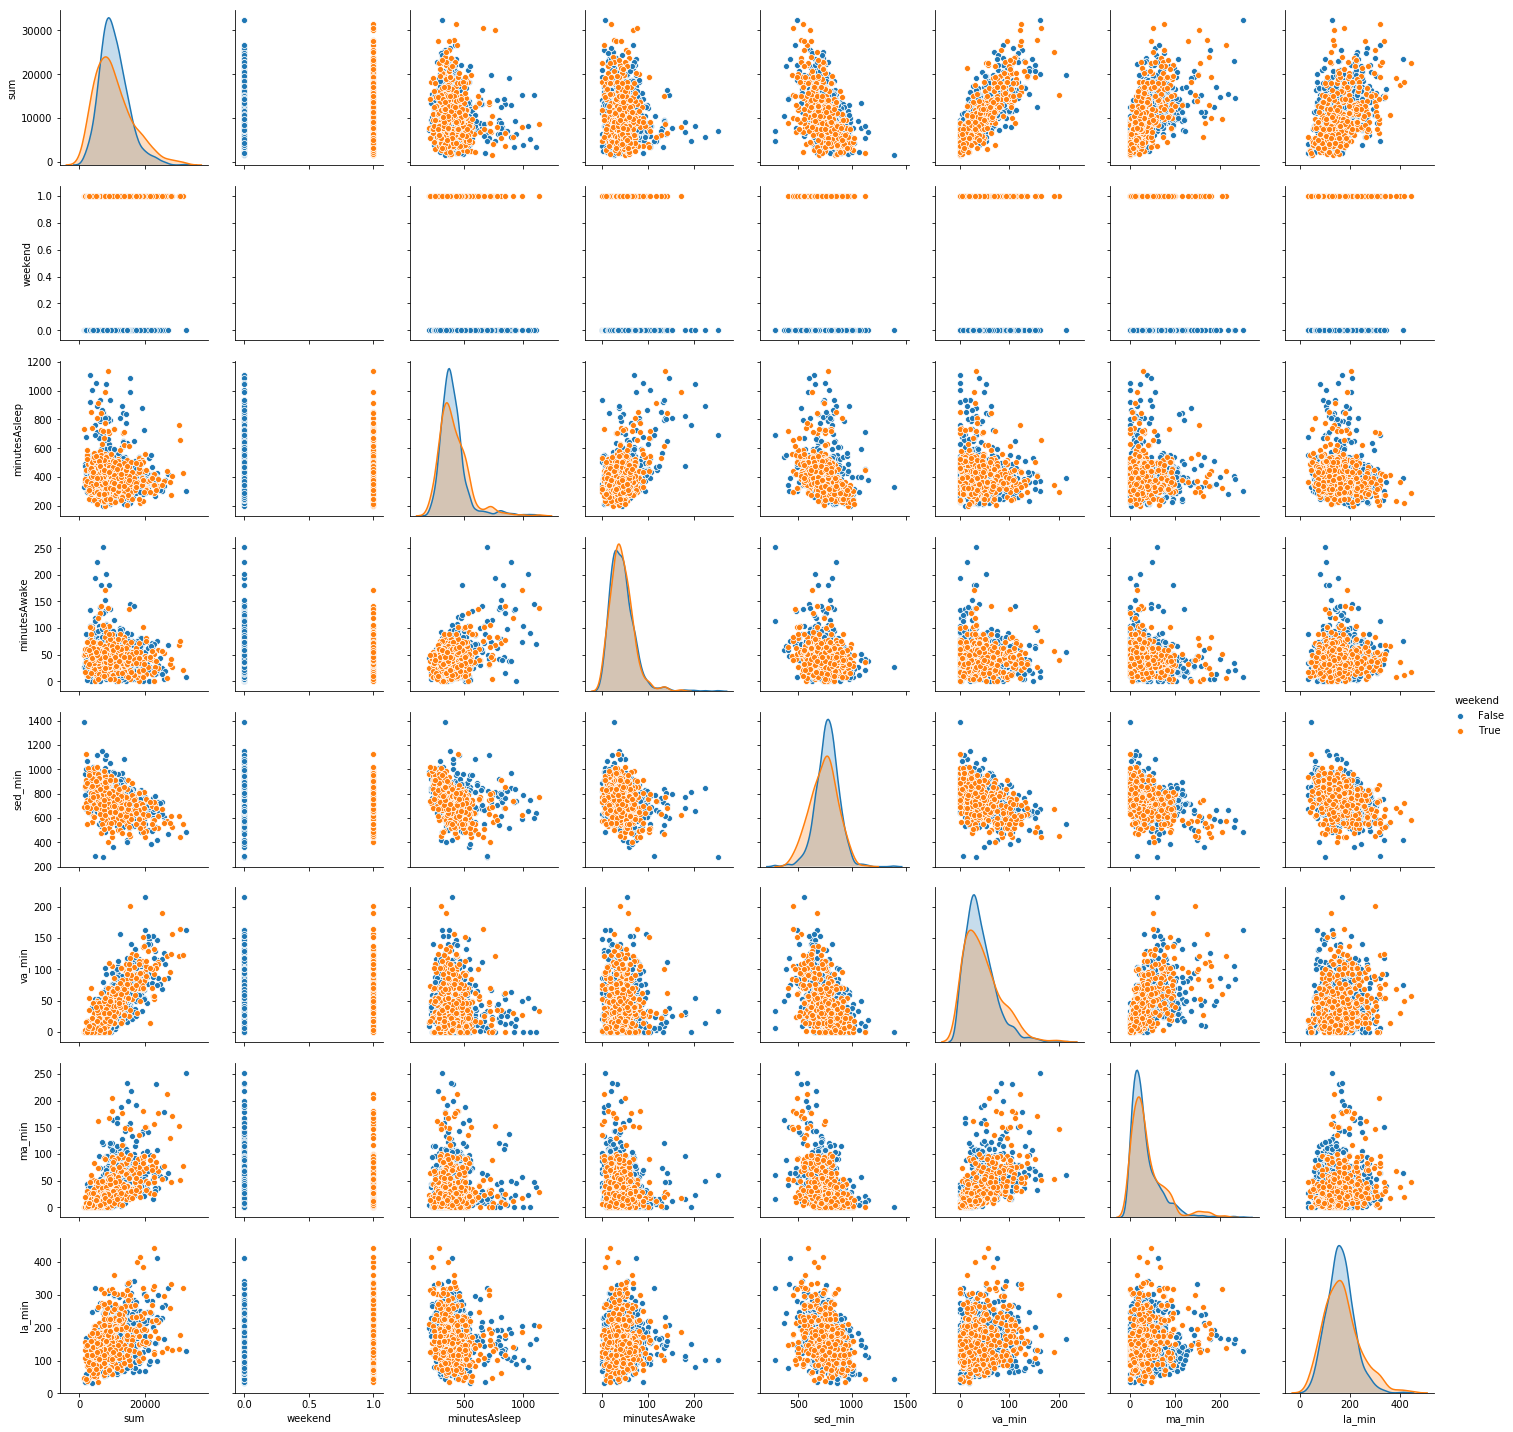

In [77]:
df_sed['sed_min'] = df_sed['value']
df_sed['date_np'] = df_sed['dateTime']
df_sed = df_sed.drop(['value','day_of_week','dateTime'],axis=1)
df_va['va_min'] = df_va['value']
df_va['date_np'] = df_va['dateTime']
df_va = df_va.drop(['value','day_of_week','dateTime'],axis=1)
df_ma['ma_min'] = df_ma['value']
df_ma['date_np'] = df_ma['dateTime']
df_ma = df_ma.drop(['value','day_of_week','dateTime'],axis=1)
df_la['la_min'] = df_la['value']
df_la['date_np'] = df_la['dateTime']
df_la = df_la.drop(['value','day_of_week','dateTime'],axis=1)
Merged = Merged.merge(df_sed,on=['weekend','date_np'],how='inner')
Merged = Merged.merge(df_va,on=['weekend','date_np'],how='inner')
Merged = Merged.merge(df_ma,on=['weekend','date_np'],how='inner')
Merged = Merged.merge(df_la,on=['weekend','date_np'],how='inner')
sns.pairplot(Merged,hue='weekend')

In [78]:
Merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1275 entries, 0 to 1274
Data columns (total 9 columns):
sum              1275 non-null int64
date_np          1275 non-null datetime64[ns]
weekend          1275 non-null bool
minutesAsleep    1275 non-null int64
minutesAwake     1275 non-null int64
sed_min          1275 non-null int64
va_min           1275 non-null int64
ma_min           1275 non-null int64
la_min           1275 non-null int64
dtypes: bool(1), datetime64[ns](1), int64(7)
memory usage: 130.9 KB


In [85]:
Merged[Merged.weekend].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 1272
Data columns (total 9 columns):
sum              351 non-null int64
date_np          351 non-null datetime64[ns]
weekend          351 non-null bool
minutesAsleep    351 non-null int64
minutesAwake     351 non-null int64
sed_min          351 non-null int64
va_min           351 non-null int64
ma_min           351 non-null int64
la_min           351 non-null int64
dtypes: bool(1), datetime64[ns](1), int64(7)
memory usage: 25.0 KB


In [116]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import QuantileTransformer
X_train, X_test, y_train, y_test = train_test_split(Merged.drop(['weekend','date_np'],axis=1), Merged['weekend'].astype(int), test_size=0.2, stratify=Merged['weekend'].astype(int),random_state=42)
#scaler = StandardScaler()
rng = np.random.RandomState(304)
scaler = QuantileTransformer(output_distribution='normal',random_state=rng)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [117]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1020 entries, 808 to 1151
Data columns (total 7 columns):
sum              1020 non-null int64
minutesAsleep    1020 non-null int64
minutesAwake     1020 non-null int64
sed_min          1020 non-null int64
va_min           1020 non-null int64
ma_min           1020 non-null int64
la_min           1020 non-null int64
dtypes: int64(7)
memory usage: 63.8 KB


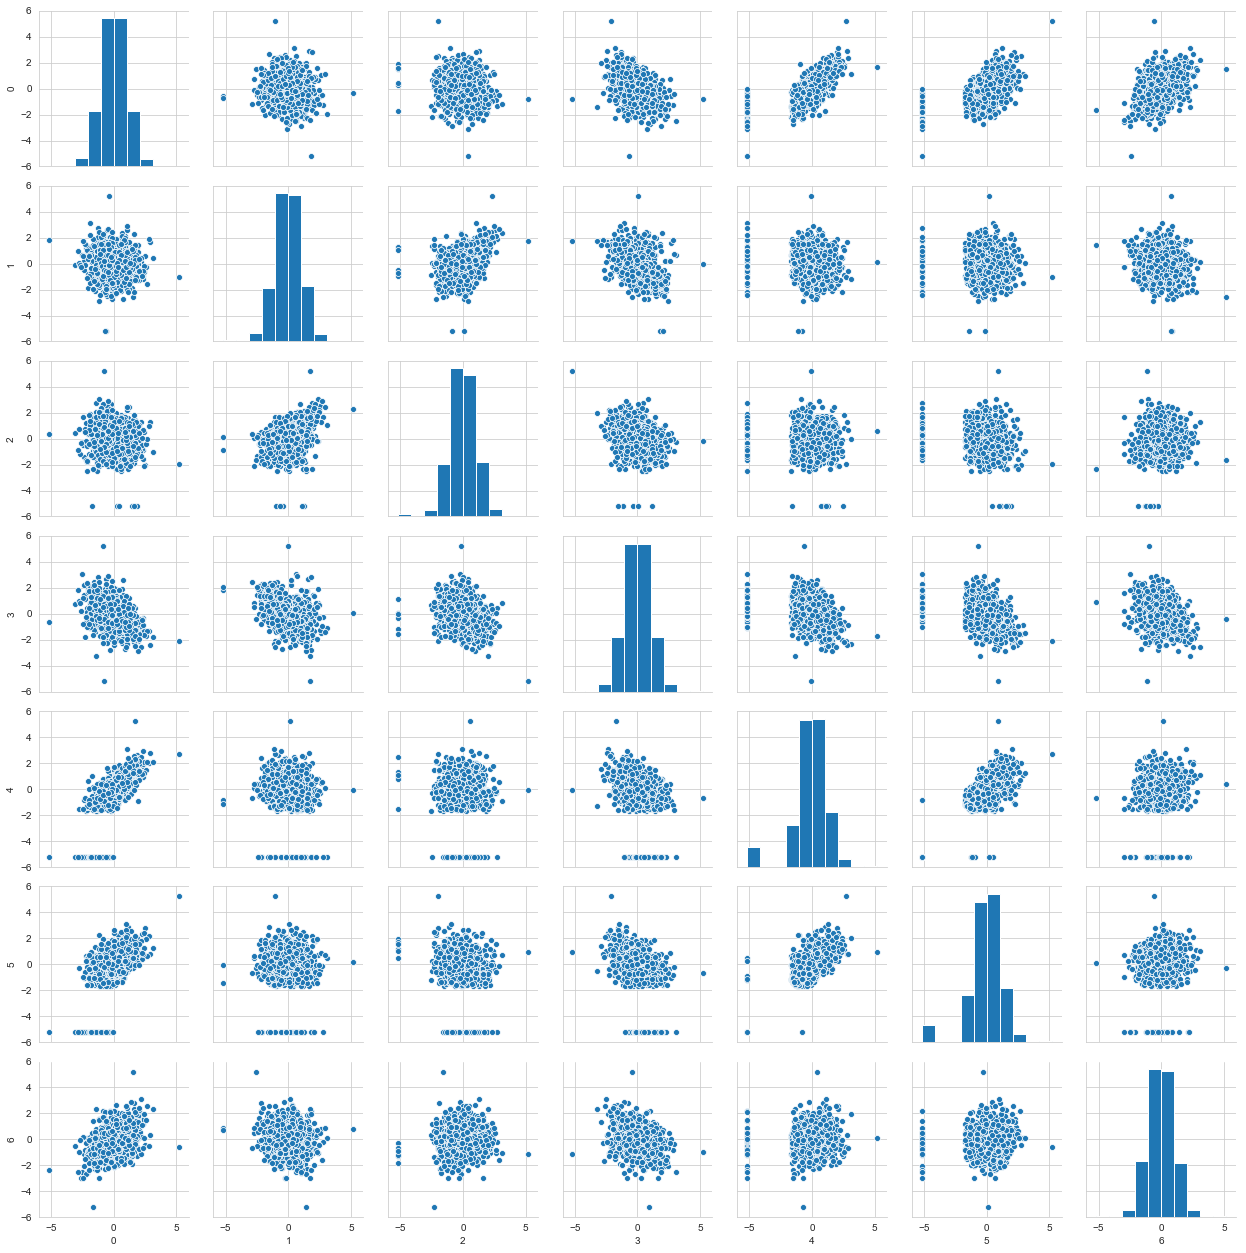

In [118]:
sns.pairplot(pd.DataFrame(X_train_scaled))

In [119]:
sum(y_train)/len(y_train)

0.2754901960784314

In [120]:
len(Merged[Merged.weekend])/len(Merged)

0.2752941176470588

In [137]:
len(X_train_scaled[0])

7

https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

In [121]:
# baseline model
def create_baseline():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(7, input_dim=7, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_smaller():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(4, input_dim=7, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_larger():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(7, input_dim=7, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_default_plus():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(7, input_dim=7, kernel_initializer='uniform', activation='sigmoid'))
    model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________

....................................................................................................
.......................................

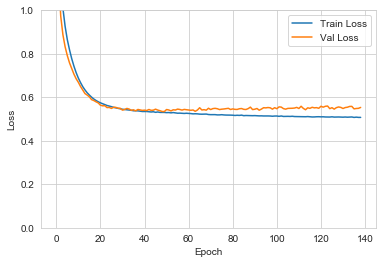

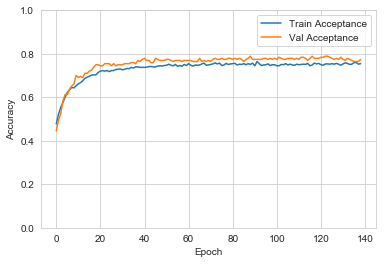

              precision    recall  f1-score   support

           0       0.88      0.75      0.81       217
           1       0.21      0.39      0.28        38

   micro avg       0.69      0.69      0.69       255
   macro avg       0.54      0.57      0.54       255
weighted avg       0.78      0.69      0.73       255

[[162  55]
 [ 23  15]]


In [122]:
# https://www.tensorflow.org/tutorials/keras/basic_regression
# The patience parameter is the amount of epochs to check for improvement

def plot_history(history):
  sns.set_style("whitegrid")
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
  plt.ylim([0,1])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'],
           label='Train Acceptance')
  plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val Acceptance')
  plt.ylim([0,1])
  plt.legend()
  plt.show()
    
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=50)

model = create_baseline()
model.summary()

history = model.fit(X_train_scaled, y_train, epochs=EPOCHS*10,
                    validation_split = 0.2, verbose=0, batch_size=5, callbacks=[early_stop, PrintDot()])

plot_history(history)

pred = model.predict(X_test_scaled)
print(classification_report((pred > .5).astype(int),y_test))
print(confusion_matrix((pred > .5).astype(int),y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 4)                 32        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________

...............................................................................................

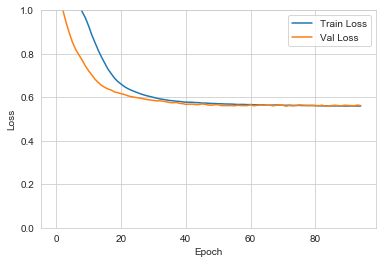

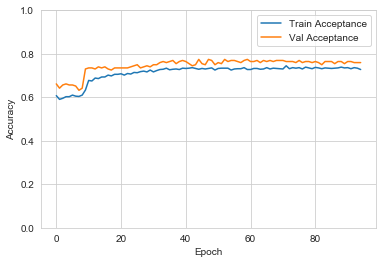

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       237
           1       0.13      0.50      0.20        18

   micro avg       0.73      0.73      0.73       255
   macro avg       0.54      0.62      0.52       255
weighted avg       0.89      0.73      0.79       255

[[176  61]
 [  9   9]]


In [123]:
model = create_smaller()
model.summary()
history = model.fit(X_train_scaled, y_train, epochs=EPOCHS*10,
                    validation_split = 0.2, verbose=0, batch_size=5, callbacks=[early_stop, PrintDot()])

plot_history(history)

pred = model.predict(X_test_scaled)
print(classification_report((pred > .5).astype(int),y_test))
print(confusion_matrix((pred > .5).astype(int),y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 32        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________

....................................................................................................
.........

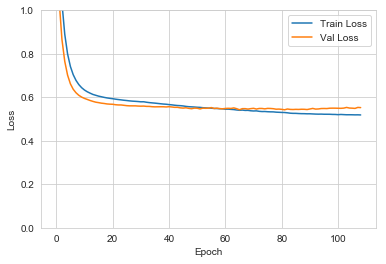

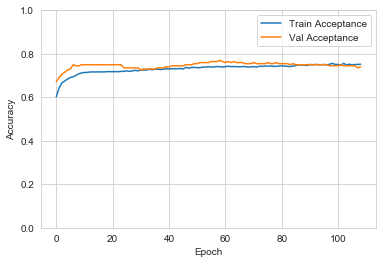

              precision    recall  f1-score   support

           0       0.94      0.73      0.82       236
           1       0.10      0.37      0.16        19

   micro avg       0.71      0.71      0.71       255
   macro avg       0.52      0.55      0.49       255
weighted avg       0.87      0.71      0.77       255

[[173  63]
 [ 12   7]]


In [124]:
model = create_larger()
model.summary()
history = model.fit(X_train_scaled, y_train, epochs=EPOCHS*10,
                    validation_split = 0.2, verbose=0, batch_size=5, callbacks=[early_stop, PrintDot()])

plot_history(history)

pred = model.predict(X_test_scaled)
print(classification_report((pred > .5).astype(int),y_test))
print(confusion_matrix((pred > .5).astype(int),y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________

...............................................................................................

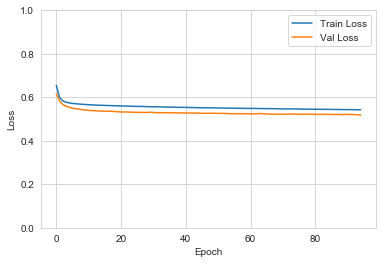

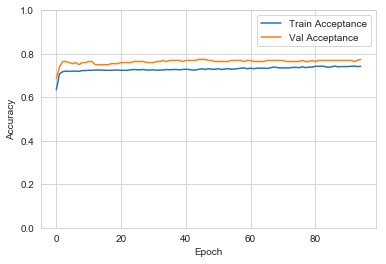

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       238
           1       0.14      0.59      0.23        17

   micro avg       0.74      0.74      0.74       255
   macro avg       0.55      0.67      0.54       255
weighted avg       0.91      0.74      0.80       255

[[178  60]
 [  7  10]]


In [125]:
model = create_default_plus()
model.summary()
history = model.fit(X_train_scaled, y_train, epochs=EPOCHS*10,
                    validation_split = 0.2, verbose=0, batch_size=5, callbacks=[early_stop, PrintDot()])

plot_history(history)

pred = model.predict(X_test_scaled)
print(classification_report((pred > .5).astype(int),y_test))
print(confusion_matrix((pred > .5).astype(int),y_test))

In [126]:
X_train_full = Merged.drop(['weekend','date_np'],axis=1)
y_train_full = Merged['weekend'].astype(int)

In [128]:
from sklearn.pipeline import Pipeline
estimators = []
estimators.append(('quantile-ize', QuantileTransformer(output_distribution='normal')))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 72.84% (2.88%)


In [129]:
estimators = []
estimators.append(('quantile-ize', QuantileTransformer(output_distribution='normal')))
estimators.append(('mlp', KerasClassifier(build_fn=create_smaller, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 72.36% (2.54%)


In [130]:
estimators = []
estimators.append(('quantile-ize', QuantileTransformer(output_distribution='normal')))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 72.26% (1.99%)


In [131]:
estimators = []
estimators.append(('quantile-ize', QuantileTransformer(output_distribution='normal')))
estimators.append(('mlp', KerasClassifier(build_fn=create_default_plus, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 73.04% (1.49%)


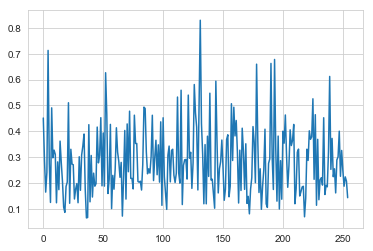

In [143]:
plt.plot(pred)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a66fe8160>]],
      dtype=object)

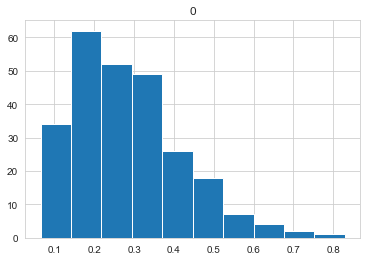

In [145]:
pd.DataFrame(pred).hist()